In [1]:
from src.ALMApy import get_k2_vs_radius
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})

Here we asses how the $k_2$ love number changes with differing sizes of the atmosphere. We use a solid (rocky) homogeneous core with an atmosphere of varying size. The fiducial parameters are:
- The core radius is equal to the radius of Neptune, $R_\mathrm{Nep}=24\times 10^6\textrm{ m}$.
- The core density is equal to the density of Neptune, $\rho_\mathrm{Nep}=1642\textrm{ kg m}^{-3}$.
- The core rigidity is taken from ALMA3's `simple-Earth` model, which is $10^11$
- The core viscosity is taken from ALMA3's `simple-Earth` model, which is $10^21$
- The atmosphere starts at the outer radius of the core, and extends to varying radii, up to the radius of Jupiter $R_\mathrm{Jup}=69.6\times 10^6\textrm{ m}$
- The atmosphere has a density equal to the density of the atmosphere at the surface of the earth, $\rho_\mathrm{air}=1.293\textrm{kg m}^{-3}$
- The atmosphere's viscosity is equal to the viscosity of air, $\nu=5\times 10^{-5}$
- The atmosphere's rigiditiy is negligible

In [2]:
G = 6.67e-11

# Dimensions
R_jupiter = 69.9e6
m_neptune = 1.024e26
R_neptune = 24.6e6
rho_neptune = m_neptune/(4*np.pi/3*R_neptune**3)

# Material properties
rho_air = 1.293
rigidity_air = 1e-7
viscosity_air = 3e-5
rigidity_earth = 1e11
viscosity_earth = 1e21


### Love Number of homogeneous sphere
The Love number of a homogeneous sphere is given by
$$
k_2=\frac{3}{2\left(1+\frac{19\mu}{2\rho gR}\right)}
$$
with $\mu$ the rigidity, $\rho$ the density, $g=\frac{4\pi}{3}G\rho R$ the surface gravity and $R$ the radius.

In [13]:
def get_k2_core(R_core, mu_core, rho_core):
    g_core = 4*np.pi/3*G*rho_core*R_core
    return 3/(2*(1+19*mu_core/(2*g_core*rho_core*R_core)))

### Varying core radii

In [4]:
no_atm_radii = 100
log_max_atm_radius = 1 #maximum radius = 10**log_max_atm_radius * R_jupiter

no_core_radii = 10
min_core_radius = 0.5*R_neptune
max_core_radius = 5*R_neptune
core_radii = np.linspace(min_core_radius, max_core_radius, no_core_radii)

data = []

rerun_sim = False
if rerun_sim:
    for i,core_radius in enumerate(core_radii):
        atmosphere_radii = (np.logspace(-3,log_max_atm_radius,no_atm_radii)-10**-3)*R_jupiter+core_radius
        k2 = get_k2_vs_radius(core_radius, atmosphere_radii, [rho_air, rho_neptune], [rigidity_air, rigidity_earth], [viscosity_air, viscosity_earth])
        data.append({"core_radius": core_radius,
                     "radius": atmosphere_radii,
                     "k2": k2,})
        print(f"{(i+1)/len(core_radii)*100:.0f}% done")
    np.save("k2_fitting_data.npy", data)
else:
    data = np.load("k2_fitting_data.npy", allow_pickle=True)

### Default plot

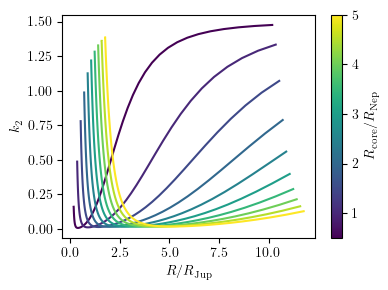

In [6]:
norm = mcolors.Normalize(vmin=min_core_radius/R_neptune, vmax=max_core_radius/R_neptune)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
for i,core_radius in enumerate(core_radii):
    ax.plot(data[i]["radius"]/R_jupiter, data[i]["k2"], color=cmap(norm(core_radius/R_neptune)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

ax.set_xlabel("$R/R_\\mathrm{Jup}$")
ax.set_ylabel("$k_2$")
fig.tight_layout()
fig.savefig("figures/k2_vs_R.png", dpi=300)
plt.show()


### Log-scale

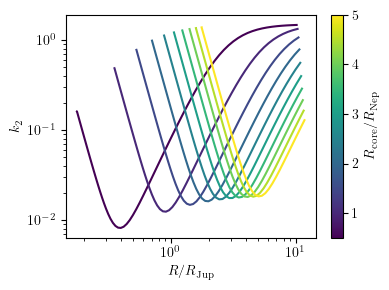

In [7]:
fig, ax = plt.subplots(figsize=(4,3))
for i,core_radius in enumerate(core_radii):
    ax.plot(data[i]["radius"]/R_jupiter, data[i]["k2"], color=cmap(norm(core_radius/R_neptune)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

ax.set_xlabel("$R/R_\\mathrm{Jup}$")
ax.set_ylabel("$k_2$")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()
fig.savefig("figures/k2_vs_R_log.png", dpi=300)
plt.show()


### Relative to $R_\mathrm{core}$

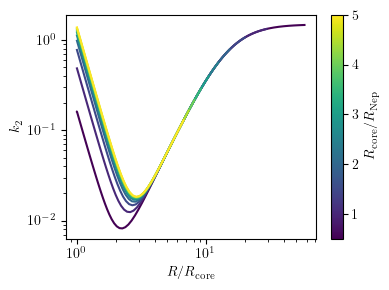

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
for i,core_radius in enumerate(core_radii):
    ax.plot(data[i]["radius"]/core_radius, data[i]["k2"], color=cmap(norm(core_radius/R_neptune)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2$")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()
fig.savefig("figures/k2_vs_R_log.png", dpi=300)
plt.show()

### Migration rate $k_2R^5$

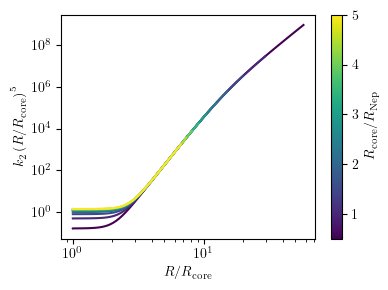

In [12]:
R_min = np.zeros(no_core_radii)

fig, ax = plt.subplots(figsize=(4,3))
for i,core_radius in enumerate(core_radii):
    idx_min = np.argmin(data[i]["k2"])
    R_min[i] = data[i]["radius"][idx_min]
    ax.plot(data[i]["radius"]/core_radius, data[i]["k2"]*(data[i]["radius"]/core_radius)**5, color=cmap(norm(core_radius/R_neptune)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()
fig.savefig("figures/k2R5_vs_R_Rcore.png", dpi=300)
plt.show()


### Elastic limit
When we have a very large atmosphere, it becomes dominant and the core negligible. Therefore the planet behaves as a homogeneous sphere of fluid, with zero rigidity, which has $k_2=3/2$

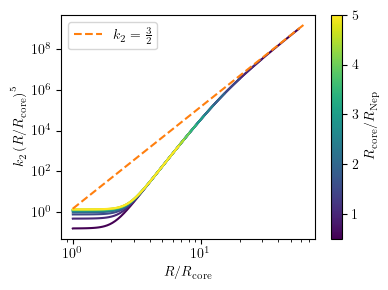

In [19]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(no_core_radii):
    R_core = data[i]["core_radius"]
    R = data[i]["radius"]
    k2 = data[i]["k2"]
    ax.plot(R/R_core, k2*(R/R_core)**5, color=cmap(norm(R_core/R_neptune)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

x = np.logspace(0,1.8,100)
ax.plot(x,3/2*x**5, color="C1", linestyle="--", label="$k_2=\\frac{3}{2}$")
ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()
ax.legend()
fig.savefig("figures/k2R5_vs_R_Rcore_x5.png", dpi=300)
plt.show()


### Elastic limit
When the atmosphere is very small, it has no effect at all on the migration rate, so
$$
\frac{a}{\dot{a}}\propto k_2 R^5\approx k_{2,\mathrm{core}}R_\mathrm{core}^5
$$
such that
$$
k_2 \left(R/R_\mathrm{core}\right)^5=k_{2,\mathrm{core}}
$$

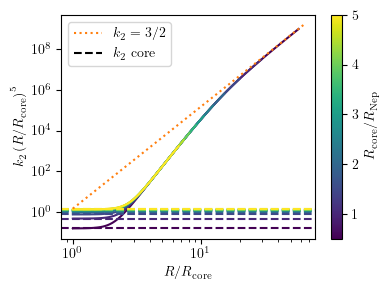

In [17]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(no_core_radii):
    R_core = data[i]["core_radius"]
    R = data[i]["radius"]
    k2 = data[i]["k2"]
    ax.plot(R/R_core, k2*(R/R_core)**5, color=cmap(norm(R_core/R_neptune)))
    ax.axhline(get_k2_core(R_core, rigidity_earth, rho_neptune), linestyle="--", color=cmap(norm(R_core/R_neptune)))

# Plot line for k2=3/2
R_interp = np.logspace(0,1.8,100)
ax.plot(R_interp, 3/2*R_interp**5, color="C1", linestyle=":", label="$k_2=3/2$")

# Create legend
ax.plot([], [], color="black", linestyle="--", label="$k_2$ core")

# Create colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.tight_layout()
fig.savefig("figures/k2_vs_R_k2core_32", dpi=300)
plt.show()


Zoomed-in

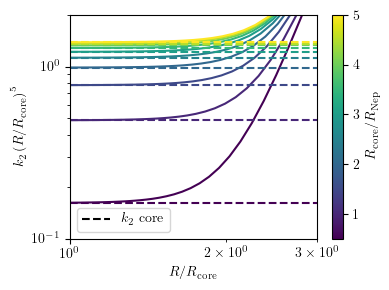

In [33]:
fig, ax = plt.subplots(figsize=(4,3))
for i,core_radius in enumerate(core_radii):
    R_core = data[i]["core_radius"]
    R_atm = data[i]["radius"]
    k2 = data[i]["k2"]
    ax.plot(R_atm/R_core, k2*(R_atm/R_core)**5, color=cmap(norm(core_radius/R_neptune)))
    ax.axhline(get_k2_core(core_radius, rigidity_earth, rho_neptune), linestyle="--", color=cmap(norm(core_radius/R_neptune)))

ax.plot([], [], color="black", linestyle="--", label="$k_2$ core")

# Create colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$R_\\mathrm{core}/R_\\mathrm{Nep}$")

ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,3)
ax.set_ylim(0.1,2)
ax.legend()
fig.tight_layout()
fig.savefig("figures/k2_vs_R_k2core_zoom.png", dpi=300)
plt.show()
